In [ ]:
%%writefile MyDataSet.py
from sklearn import datasets
import torch
import numpy as np
class MyDataSet(torch.utils.data.Dataset):
 def __init__(self):
    self.all_labels = []
    self.X, self.y = datasets.make_moons(200, noise=0.20) # entire data
 def __len__(self):
    return len(self.y)
 def __getitem__(self, index):
    # if using cross entropy loss, return following
    #return self.X[index], self.y[index] # return one pair of data, and its label
    # for MSE loss, return following (there are 2 outputs in the network)
    y2 = np.zeros(2)
    if (self.y[index] == 0):
        y2[0] = 0
        y2[1] = 1
    else:
        y2[0] = 1
        y2[1] = 0
    return self.X[index], y2

Overwriting MyDataSet.py


In [ ]:
%%writefile Utils.py
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from MyDataSet import MyDataSet
import torch
def visualize_data(self, X, y):
    plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
    plt.show()
    return X, y

def get_data_loader(batch_size=4):
    dataset = MyDataSet()
    data_loader = torch.utils.data.DataLoader(
      dataset, batch_size=batch_size, shuffle=True)
    return data_loader
def plot_decision_boundary(net, X, y):
    # set min and max values
    x_min, x_max = -2.5, 2.5
    y_min, y_max = -2.5, 2.5
    h = 0.02
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the predicted value for the whole gid
    xdata = np.c_[xx.ravel(), yy.ravel()]
    Z = net(torch.tensor(xdata).type(torch.float32).cuda()) # outputs for mesh data
    Z = np.array(Z.cpu().detach())
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training data points
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()

Writing Utils.py


In [ ]:
%%writefile Network.py
import torch
class Network(torch.nn.Module):
 def __init__(self, hidden_size, output_size=2) -> None:
    super().__init__()
    self.fc1 = torch.nn.Linear(2, hidden_size) # 2 inputs, hidden_size outputs
    self.fc2 = torch.nn.Linear(hidden_size,output_size)
    self.act = torch.nn.ReLU()
    self.sm = torch.nn.Softmax(dim=1)
 def forward(self,x):
    x = self.fc1(x)
    x = self.act(x)
    x = self.sm(self.fc2(x))
    return x

Overwriting Network.py


epoch: 0  loss= 29.639319176319987
epoch: 1  loss= 21.01336681239627
epoch: 2  loss= 19.07679131194891
epoch: 3  loss= 19.740997143711866
epoch: 4  loss= 17.837451251529274
epoch: 5  loss= 15.467702626876417
epoch: 6  loss= 15.128771543438688
epoch: 7  loss= 14.185903165945376
epoch: 8  loss= 13.464596717396944
epoch: 9  loss= 12.175295524855756
epoch: 10  loss= 11.192947957693036
epoch: 11  loss= 11.133143220224156
epoch: 12  loss= 10.261530453498196
epoch: 13  loss= 9.764538596451928
epoch: 14  loss= 9.590395950943744
epoch: 15  loss= 9.142096103110141
epoch: 16  loss= 9.31413861628478
epoch: 17  loss= 8.456358587996787
epoch: 18  loss= 7.382732427745536
epoch: 19  loss= 8.274243604730623
epoch: 20  loss= 8.198267680293563
epoch: 21  loss= 8.089427797002449
epoch: 22  loss= 8.12012197594657
epoch: 23  loss= 8.44506354584512
epoch: 24  loss= 7.862120684354532
epoch: 25  loss= 7.65190916019241
epoch: 26  loss= 7.382515546526976
epoch: 27  loss= 8.532360860848648
epoch: 28  loss= 7.3525

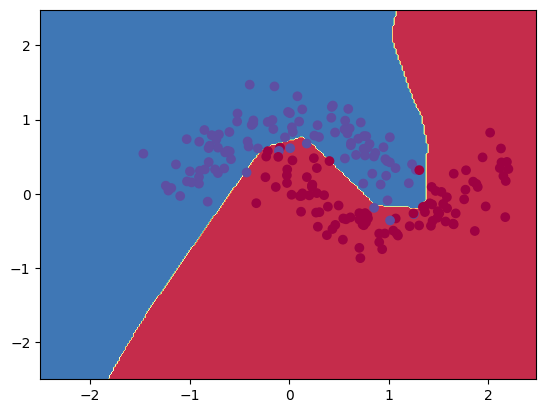

SystemExit: 0

In [ ]:
import sys
import Utils
import torch
from Network import Network
import numpy as np
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_loader = Utils.get_data_loader(batch_size=1)

    loss_fn = torch.nn.MSELoss() # torch.nn.CrossEntropyLoss()
    hidden_size = 30 # experiment by changing this to 1 or 3 or 5 or 30
    net = Network(hidden_size).to(device) # create the network
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01, momentum=0.9)
    num_epochs = 500
    net.train()
    for i in range(num_epochs):
        running_loss = 0
        #diter = iter(data_loader)
        #for x, y in diter:
        for batch_idx, (x, y) in enumerate(data_loader):
            x = x.to(device).type(torch.float32)
            y = y.to(device).type(torch.float32)
            #use long if cross entropy loss y.to(device).type(torch.long)
            optimizer.zero_grad() # clear the gradients
            outputs = net(x) # calls forward function in the Network
            loss = loss_fn(outputs, y)
            loss.backward() # compute gradients
            optimizer.step() # update weights and biases
            running_loss += loss.item()
        print('epoch:',i, ' loss=', running_loss)
    net.eval()
    accuracy = 0
    data_loader = Utils.get_data_loader(batch_size=200)
    diter = iter(data_loader)
    x, y = next(diter)
    x = x.to(device).type(torch.float32)
    y = y.to(device).type(torch.long)
    out = net(x)
    Z = np.array(out.cpu().detach())
    y = np.argmax(y.cpu().detach(), axis=1) # when using MSE loss, otherwise comment this line
    Z = np.argmax(Z, axis=1)
    y_np = np.array(y.cpu().detach())
    count = (Z == y_np).sum()
    accuracy_percent = count/len(y_np)
    print('accuracy =', accuracy_percent)
    Utils.plot_decision_boundary(net, x.cpu().detach(), y.detach().cpu())
if __name__ == "__main__":
    sys.exit(int(main() or 0))